In [8]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [9]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    #가져올때는 X_train으로 가져왔는데 mask처리로 val,text를 구분지어줌
    mask = list(range(num_training, num_training + num_validation))
    #mask = list(range(49000,50000))이 되므로 mask = [49000,49001..., 49999]인 list 변수가 된다
    X_val = X_train[mask] #val은 X_train의 49000~50000번 까지의 데이터로 설정
    y_val = y_train[mask] #즉 10%
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    #데이터에 편향 값 1을 추가해주는 코드로 편리한 계산을 위해 이 작업을 해준다.
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    #np.one는 주어진 형태의 배열을 생성하는 함수로 np.ones(a,b)를 통해 axb의 행렬을 생성함
    #np.hstack은 X_train 행렬에다가 np.ones로 생성된 행렬을 추가해주는 함수
    '''
    X_train = [1,2,3] --> [1,2,3,1]
              [4,5,6] --> [4,5,6,1]
              [7,8,9] --> [7,8,9,1] 이런식으로 추가해줌
    '''
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


**코드 결과 해석**  
CIFAR-10 데이터는 32x32 사이즈로 구성되고 rgb 채널이 3개이므로 32x32x3 = 3072의 특징을 가짐  
  
Train data의 shape가 49000,3073이라는 것은 49000의 이미지가 3073개의 특징(픽셀값+편향)으로 구성되어있다는 뜻

## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [13]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
#여기서 구현하는 W는 Softmax에서 최종 분류기로 사용되기 때문에 3073x10으로 구성
#즉, 1-layer 네트워크를 구성함
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.291534
sanity check: 2.302585


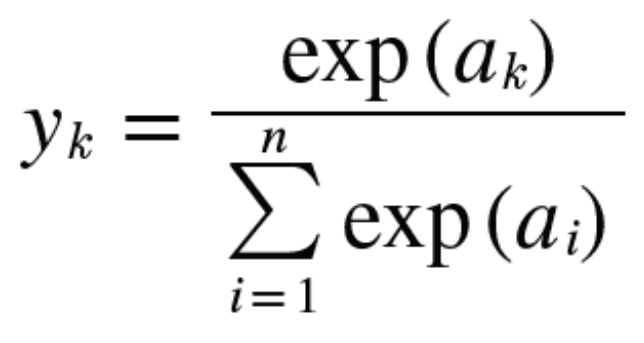  

위의 식은 Softmax 공식이다.  
Softmax로 구한 확률값은 전부 더해서 1이 된다는 특징을 가지고 있다.



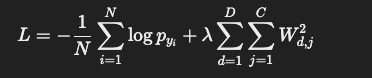  
이 식은 전체 손실함수의 구성 요소이다.

**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in*



In [14]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.377858 analytic: 1.377858, relative error: 4.627818e-08
numerical: -0.048360 analytic: -0.048360, relative error: 5.156947e-07
numerical: -1.998705 analytic: -1.998706, relative error: 4.166457e-08
numerical: 0.482657 analytic: 0.482657, relative error: 2.419437e-08
numerical: 1.694939 analytic: 1.694939, relative error: 3.921009e-08
numerical: -0.540659 analytic: -0.540659, relative error: 6.309786e-08
numerical: 1.191662 analytic: 1.191662, relative error: 4.733244e-10
numerical: 0.551345 analytic: 0.551344, relative error: 2.218260e-07
numerical: 6.980846 analytic: 6.980846, relative error: 1.859356e-08
numerical: 0.652964 analytic: 0.652964, relative error: 1.189557e-08
numerical: -1.790884 analytic: -1.790884, relative error: 1.583578e-08
numerical: -0.195765 analytic: -0.195765, relative error: 3.954113e-07
numerical: 1.241705 analytic: 1.241705, relative error: 9.920491e-08
numerical: 0.584468 analytic: 0.584468, relative error: 5.763821e-08
numerical: -1.061539 ana

In [16]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.291534e+00 computed in 0.204154s
vectorized loss: 2.291534e+00 computed in 0.023209s
Loss difference: 0.000000
Gradient difference: 0.000000


In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        # 소프트맥스 분류기 생성 및 학습
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, batch_size=200, verbose=False)

        # 학습 데이터 정확도 계산
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train_pred == y_train)

        # 검증 데이터 정확도 계산
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val_pred == y_val)

        # 결과 저장
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # 최고 성능 모델 업데이트
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax # 이 부분에서 최적의 softmax 인스턴스 (모델)을 저장함
            #즉, 가중치 W, lr 등 하이퍼 파라미터를 저장하게 됨
            #softmax인스턴스는 linerclassifer에서 softamx클래스가 해당 클래스를 상속받은 형태로 저장되어있음

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.333000 val accuracy: 0.346000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.306163 val accuracy: 0.321000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.322531 val accuracy: 0.340000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.298816 val accuracy: 0.303000
best validation accuracy achieved during cross-validation: 0.346000


In [18]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.342000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



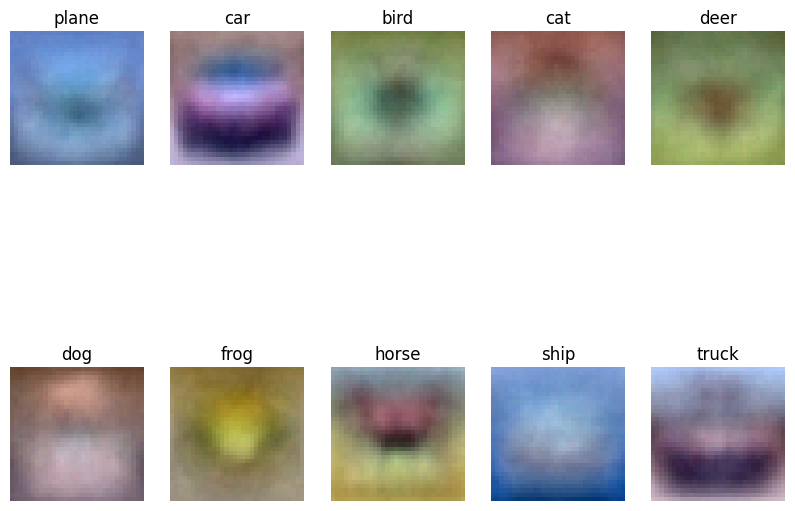

In [19]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])